In [1]:
import os
from os.path import join
from collections import Counter
import re
import requests
import pandas as pd
from nltk import sent_tokenize, word_tokenize
from tdmh import *
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances , euclidean_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ana = SentimentIntensityAnalyzer()

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
    


def extract_title(path):
    title = os.path.basename(path)
    title = re.sub( r'[.]txt$' , '' , title )
    return title



## Collect all the titles

Firstly, we collect all the titles of the files in the corpus. The texts in the corpus are saved in a list named `corpus`. 

In [2]:
authors = ['Burney Fanny',
          'Lennox Charlotte',
           'More Hannah' , 
           'Smith Charlotte' ,
         'West Jane' ,
             'Shelley Mary Wollstonecraft' ,
     'Brontë Emily' ,
 'Herr Charlotte B. (Charlotte Bronte)' ,
           'Brontë Anne' ,
           'Richardson Samuel' ,
           'Fielding Henry' ,
             'Thackeray William Makepeace' ,
           'Trollope Anthony' ]

response = requests.get('https://edu.nl/xcm3q')
if response.status_code == 200:
    csv = response.text
    with open('gutenberg_metadata.csv' , 'w' , encoding = 'utf-8') as f:
        f.write(csv)

df = pd.read_csv('gutenberg_metadata.csv' )


metadata = df[ df['author'].isin( authors ) ]
print(metadata.shape)


(221, 7)


In [3]:
texts = ['Emma', 
         'Northanger_Abbey',
         'Persuasion',
         'Mansfield_Park',
         'Pride_and_Prejudice',
         'Sense_and_Sensibility']

pos_tags = ['JJ','JJR','JJS','VBD','MD','RB','RBR','RBS']
ttr_cap = 3000

In [4]:
out = open( 'data_contemporaries.csv' , 'w' , encoding = 'utf-8' )

## Sentiment Analysis
ana = SentimentIntensityAnalyzer()

pos_tags = ['JJ','JJR','JJS','VBD','MD','RB','RBR','RBS']

## Header of the CSV file
out.write('title,author,tokens,sentences,ttr,sentiment')

for t in pos_tags:
    out.write(f',{t}')

out.write('\n')

## Jane Austen

dir = 'Corpus'
corpus = []

for text in os.listdir(dir):
    if re.search( r'txt$' , text ):
        path = join( dir, text )
        print(path)
        corpus.append(path)

Corpus/Mansfield_Park.txt
Corpus/Sense_and_Sensibility.txt
Corpus/Northanger_Abbey.txt
Corpus/Persuasion.txt
Corpus/Emma.txt
Corpus/Pride_and_Prejudice.txt


In [5]:
for text in corpus:
    
    # The dictionary named 'data' saves the data about the text
    data = dict()
    print( f'Analysing {text} ...')
    
    ## Get the title, based on the filename
    title = extract_title( text )
    author = 'Austen Jane'
    
    ## read the full text
    fh = open( text, encoding = 'utf-8')
    full_text = fh.read()
    
    ## count the number of sentences
    sentences = sent_tokenize(full_text)
    data['nr_sentences'] = len(sentences)
    
    # dictionary to count the POS tags
    freq_pos = dict()    
    
    # variables for the calculation of type-token ratio
    
    freq_ttr = dict()
 
    # token count is initalised at 0
    data['nr_tokens'] = 0
    
    # list for the sentiment scores
    all_scores = []

        
    for s in sentences:
        words = word_tokenize(s)
        words = remove_punctuation(words)
        
        tags = pos_tag(words)
        
        scores = ana.polarity_scores(s)
        all_scores.append( scores["compound"] )
        
        # Each tag consists of two values: 
        # [0]: the word and [1] the POS tag
        for word_tag in tags:
            word = word_tag[0]
            tag = word_tag[1]
            
            # count the tokens
            data['nr_tokens'] += 1
            
            # place tokens in dictionary freq_ttr
            # only if the word count is less than ttr_cap
            # The nr of items in the dictionary eventually equals the nr of types
            if data['nr_tokens'] <= ttr_cap:
                freq_ttr[ word ] = freq_ttr.get( word , 0 ) + 1
                
            ## Count frequencies of all the POS tags
            freq_pos[ tag ] = freq_pos.get( tag ,0) +1
            
    for t in pos_tags:
        data[t] = freq_pos.get(t,0)
    data['sentiment'] = sum(all_scores) / len(all_scores)

                
    # Calculate TTR: number of items in freq_ttr dictyionary
    # divided by ttr_cap
    data['ttr'] = len( freq_ttr ) / ttr_cap
    
    # write the results to a CSV file    
    out.write( f"{title},{author},{data['nr_tokens']},{data['nr_sentences']},{data['ttr']},{data['sentiment']}" )
    for t in pos_tags:
        out.write( f",{data[t] }"  )
        

        
    out.write('\n')

    

print('Done!')

Analysing Corpus/Mansfield_Park.txt ...
Analysing Corpus/Sense_and_Sensibility.txt ...
Analysing Corpus/Northanger_Abbey.txt ...
Analysing Corpus/Persuasion.txt ...
Analysing Corpus/Emma.txt ...
Analysing Corpus/Pride_and_Prejudice.txt ...
Done!


In [6]:
## Contemporary authors

dir = 'Contemporary_authors'
corpus = []

for text in os.listdir(dir):
    if re.search( r'txt$' , text ):
        path = join( dir, text )
        #print(path)
        corpus.append(path)

## metadata for these texts
text_data = dict()

for i,row in metadata.iterrows():
    text_id = join( dir, os.path.basename(row['url']) )
    author = row['author']
    title = row['title']
    text_data[text_id] = ( author, title )
    


In [7]:
for text in corpus:
    
    # The dictionary named 'data' saves the data about the text
    data = dict()

    
    ## Get the title, based on the filename
    title = text_data[text][1]
    author = text_data[text][0]
    
    print( f'Analysing {title} by {author}  ...')
    
    ## read the full text
    fh = open( text, encoding = 'utf-8')
    full_text = fh.read()
    
    ## count the number of sentences
    sentences = sent_tokenize(full_text)
    data['nr_sentences'] = len(sentences)
    
    # dictionary to count the POS tags
    freq_pos = dict()    
    
    # variables for the calculation of type-token ratio
    
    freq_ttr = dict()
 
    # token count is initalised at 0
    data['nr_tokens'] = 0
    
    # list for the sentiment scores
    all_scores = []

        
    for s in sentences:
        words = word_tokenize(s)
        words = remove_punctuation(words)
        
        tags = pos_tag(words)
        
        scores = ana.polarity_scores(s)
        all_scores.append( scores["compound"] )
        
        # Each tag consists of two values: 
        # [0]: the word and [1] the POS tag
        for word_tag in tags:
            word = word_tag[0]
            tag = word_tag[1]
            
            # count the tokens
            data['nr_tokens'] += 1
            
            # place tokens in dictionary freq_ttr
            # only if the word count is less than ttr_cap
            # The nr of items in the dictionary eventually equals the nr of types
            if data['nr_tokens'] <= ttr_cap:
                freq_ttr[ word ] = freq_ttr.get( word , 0 ) + 1
                
            ## Count frequencies of all the POS tags
            freq_pos[ tag ] = freq_pos.get( tag ,0) +1
            
    for t in pos_tags:
        data[t] = freq_pos.get(t,0)
    data['sentiment'] = sum(all_scores) / len(all_scores)

                
    # Calculate TTR: number of items in freq_ttr dictyionary
    # divided by ttr_cap
    data['ttr'] = len( freq_ttr ) / ttr_cap
    
    # write the results to a CSV file    
    out.write( f"{title},{author},{data['nr_tokens']},{data['nr_sentences']},{data['ttr']},{data['sentiment']}" )
    for t in pos_tags:
        out.write( f",{data[t] }"  )
        

        
    out.write('\n')

    

print('Done!')

Analysing History of Tom Jones a Foundling by Fielding Henry  ...
Analysing The House of Heine Brothers in Munich by Trollope Anthony  ...
Analysing Barchester Towers by Trollope Anthony  ...
Analysing Sir Harry Hotspur of Humblethwaite by Trollope Anthony  ...
Analysing The Mistletoe Bough by Trollope Anthony  ...
Analysing Pamela Volume II by Richardson Samuel  ...
Analysing The Diary and Letters of Madame DArblay — Volume 1 by Burney Fanny  ...
Analysing Stories for the Young; Or Cheap Repository Tracts\r\nEntertaining Moral and Religious. Vol. VI. by More Hannah  ...
Analysing Camilla; or A Picture of Youth by Burney Fanny  ...
Analysing The Courtship of Susan Bell by Trollope Anthony  ...
Analysing A Journey from This World to the Next by Fielding Henry  ...
Analysing Can You Forgive Her? by Trollope Anthony  ...
Analysing The Inflexible Captive: A Tragedy in Five Acts by More Hannah  ...
Analysing The History of Pendennis by Thackeray William Makepeace  ...
Analysing Why Frau Fro

Analysing Clarissa Harlowe; or the history of a young lady — Volume 8 by Richardson Samuel  ...
Analysing The West Indies and the Spanish Main by Trollope Anthony  ...
Analysing Some Roundabout Papers by Thackeray William Makepeace  ...
Analysing The Tenant of Wildfell Hall by Brontë Anne  ...
Analysing Mrs. General Talboys by Trollope Anthony  ...
Analysing Coelebs In Search of a Wife by More Hannah  ...
Analysing North America — Volume 2 by Trollope Anthony  ...
Analysing The Bertrams by Trollope Anthony  ...
Analysing The Works of Henry Fielding vol. 12 by Fielding Henry  ...
Analysing A Little Dinner at Timminss by Thackeray William Makepeace  ...
Analysing The Relics of General Chasse: A Tale of Antwerp by Trollope Anthony  ...
Analysing Evelina Or the History of a Young Ladys Entrance into the World by Burney Fanny  ...
Analysing The Wanderer; or Female Difficulties (Volume 4 of 5) by Burney Fanny  ...
Analysing Clarissa Harlowe; or the history of a young lady — Volume 5 by Richa

In [8]:
out.close()

## Read the data from the CSV

Once the CSV file containing all the data has been created, we can start the analyses. The data is firstly read using the `read_csv()` method from `pandas`. 

In [49]:
data = pd.read_csv('data_contemporaries.csv')
#data.head()

def set_class(author):
    class_label = 'Contemporary'
    if author == "Austen Jane":
        class_label = 'Austen'
    return class_label

def shorten_title(title,max=12):
    new_title = title[:max] 
    if len(title) > max:
        return new_title + ' ...'
    else:
        return new_title
    
data['class'] = data['author'].apply(set_class)
data['title'] = data['title'].apply(shorten_title)


## Visualisations

In many of the visualisations below, the colours represent the different values for a categorical variable in the CSV file named 'metdata.csv'. 
In the cell below, specify the column containing the values that need to be visualised. 


### Average sentence length

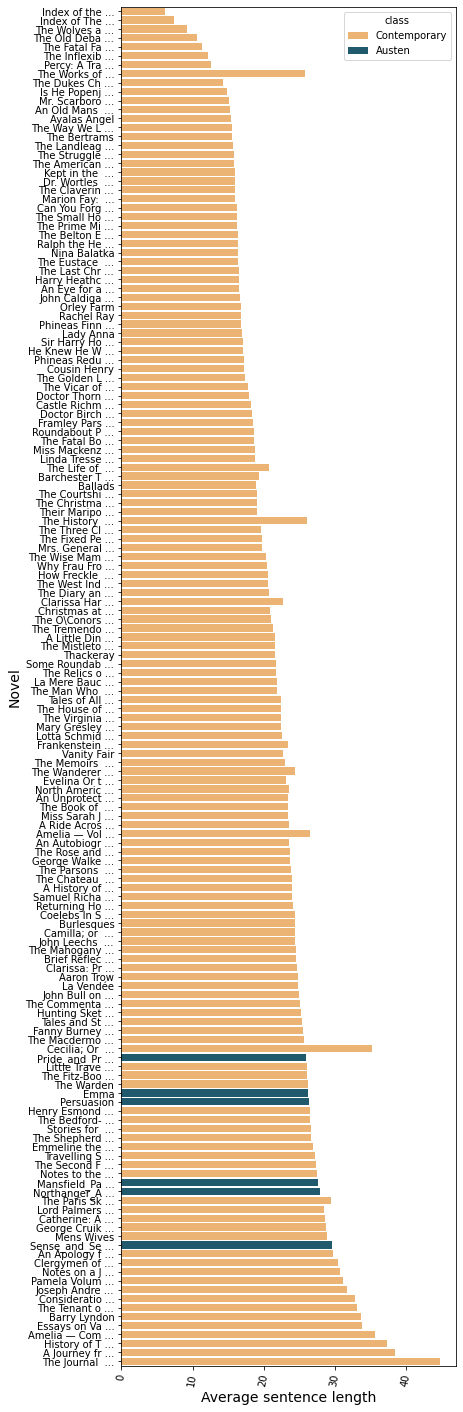

In [60]:
data['sentence_length'] = data['tokens'] / data['sentences']

y_axis = 'title'
x_axis = 'sentence_length'
hue = 'class'

data_sorted = data.sort_values( by = x_axis )

colours = ['#ffb560' , '#15607a']
fig = plt.figure( figsize=( 6 , 25 ) )


graph = sns.barplot( data = data_sorted , x=x_axis, 
                    y=y_axis, hue = hue , dodge=False , 
                    palette = colours , ci=None )

#graph.set_title('' , size = 20) 
graph.set_ylabel('Novel' , size = 14) 
graph.set_xlabel('Average sentence length' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot


plt.show()

### Type-token ratio

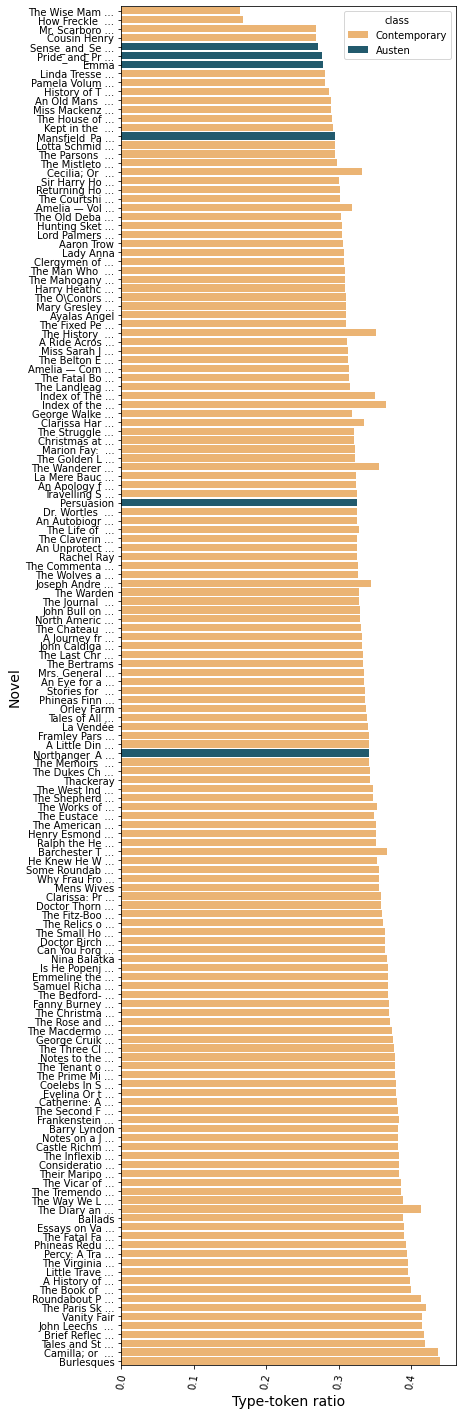

In [59]:
y_axis = 'title'
x_axis = 'ttr'

data_sorted = data.sort_values( by = x_axis )

fig = plt.figure( figsize=( 6 , 25 ) )

graph = sns.barplot( data = data_sorted , x=x_axis, 
                    y=y_axis, hue = hue , dodge=False , 
                    palette = colours , ci=None )

#graph.set_title('' , size = 20) 
graph.set_ylabel('Novel' , size = 14) 
graph.set_xlabel('Type-token ratio' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot


plt.show()

### Modal verbs

Can you add code to do a comparative analysis of the use of modal verbs? The POS code for modal verbs is 'MD'

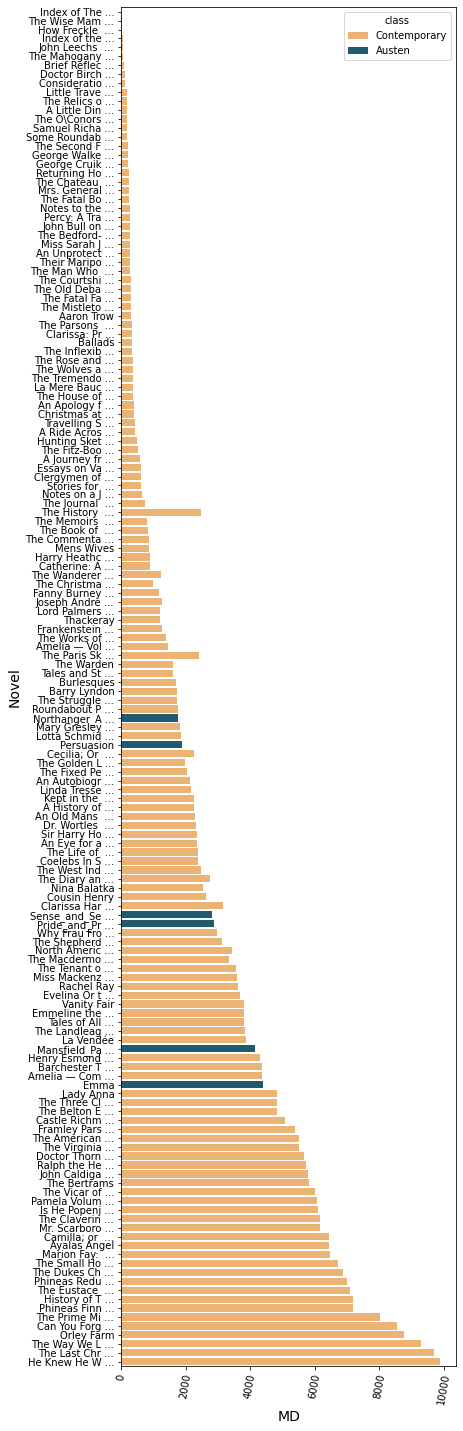

In [58]:
y_axis = 'title'
x_axis = 'MD'

data_sorted = data.sort_values( by = x_axis )


fig = plt.figure( figsize=( 6 , 25 ) )

graph = sns.barplot( data = data_sorted , x=x_axis, 
                    y=y_axis, hue = hue , dodge=False , 
                    palette = colours , ci=None )

#graph.set_title('' , size = 20) 
graph.set_ylabel('Novel' , size = 14) 
graph.set_xlabel('MD' , size = 14 )

plt.xticks(rotation= 80)


plt.show()

### Adjectives and Adverbs

Text(0, 0.5, 'adjectives')

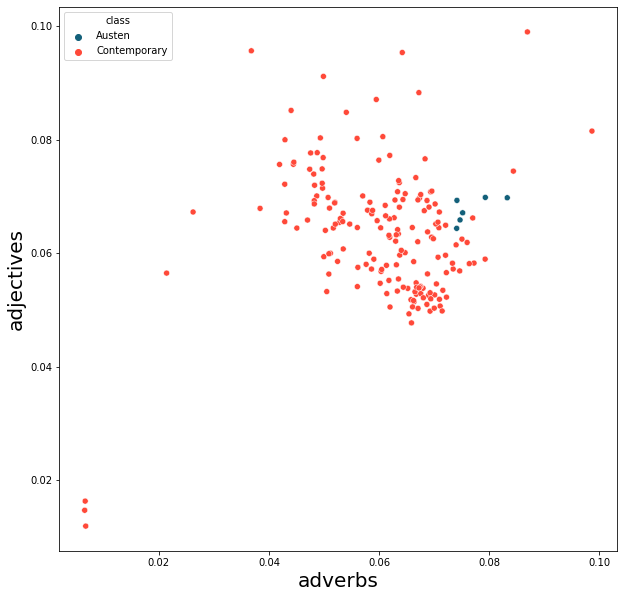

In [64]:
data['adjectives'] = data['JJ'] + data['JJS'] + data['JJS']
data['adverbs'] = data['RB'] + data['RBR'] + data['RBS'] 
data['adjectives'] = data['adjectives'] / data['tokens']
data['adverbs'] = data['adverbs'] / data['tokens']

# Columns to use in the visualisation
y_axis = 'adjectives'
x_axis = 'adverbs'
hue = 'class'

colours = ['#13607a','#ff4939']

fig = plt.figure( figsize = ( 10,10 ))

ax = sns.scatterplot( data=data , x=x_axis, y=y_axis,  
                    hue =  hue , palette = colours )

# for index, row in data.iterrows():
#     plt.text( row[x_axis], row[y_axis] , row['title'] , fontsize=12.8)


ax.set_xlabel( x_axis  , fontsize = 20 )
ax.set_ylabel( y_axis  , fontsize = 20 )



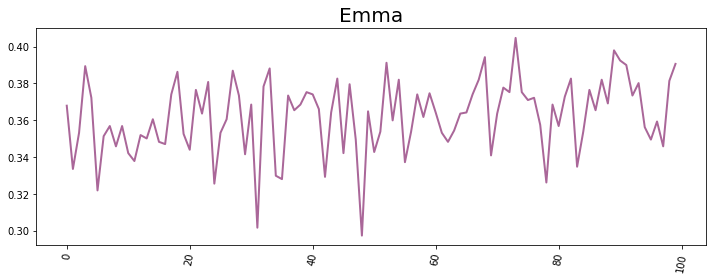

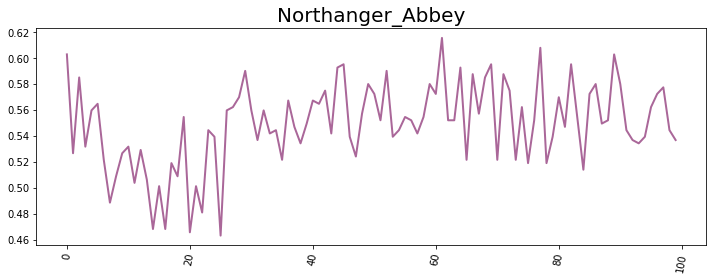

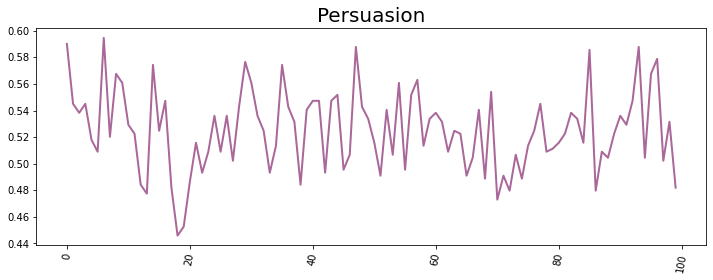

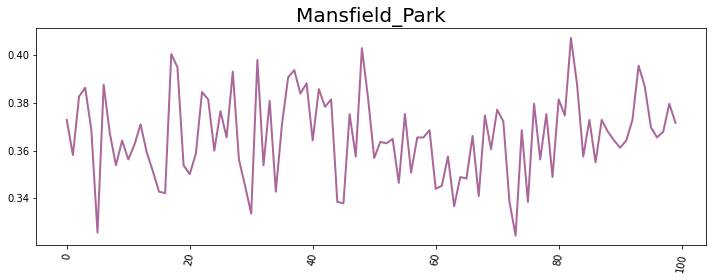

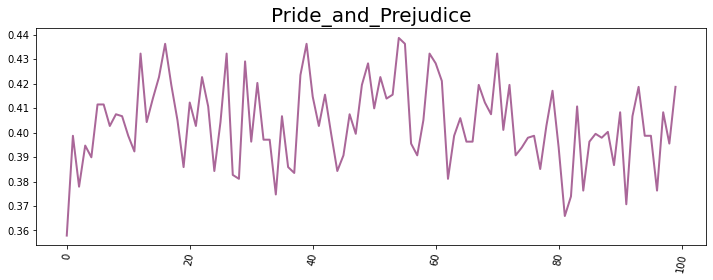

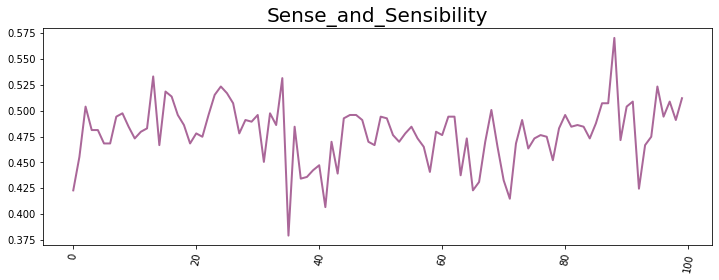

In [65]:
for text in texts:

    data = []
    tokens = pd.read_csv( join('Data',f'{text.lower()}.tokens') , sep = '\t')

    full_text = ''

    for i,row in tokens.iterrows():
        if row['POS_tag'] != 'PUNCT':
            full_text += row['word'] + ' '



    segments = 100

    words = nltk.word_tokenize(full_text)

    segment_length = math.ceil( len(words)/segments )

    i = 0 

    while i < len(words):
        segment_words = words[i:i+segment_length]
        i += segment_length
        ttr = len(set(segment_words))/segment_length
        data.append(ttr)

    import seaborn as sns
    import matplotlib.pyplot as plt


    x_axis = [i for i in range (100)]
    y_axis = data



    fig = plt.figure( figsize = ( 12, 4))
    ax = sns.lineplot(x= x_axis, y=y_axis, 
                      color= '#AA6799', linestyle='solid',linewidth=2 )
    ax.set_title( text , size = 20) 
    
    plt.xticks(rotation= 80)
    plt.show()